<a href="https://colab.research.google.com/github/philip-pearce/bloodflow/blob/main/network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction**

In this mini-project, we model blood flow in a network of capillaries, and solve the equations using matrices. There are activities for beginners (e.g. high school students) and intermediate activities (e.g. for undergraduates) and more open-ended activities for advanced practitioners (e.g. advanced undergraduates and postgraduates).

# **Background**




**Modelling blood flow**

The simplest model of blood flow in a capillary uses Poiseuille's law. This law states that the flow rate $Q$ of blood through a capillary is related to the pressure difference across the capillary $\Delta P$, and the resistance of the capillary $R$, as follows:

\begin{equation}
  Q = \frac{\Delta P}{R}
\end{equation}

The vascular resistance $R$ can be calculated from the viscosity $\mu$ of blood, the radius $H$ of the capillary, and the length $L$ of the capillary as follows:

\begin{equation}
  R = \frac{8 \mu L}{\pi H^4}
\end{equation}

We represent a network of capillaries as a set of edges, which represent capillaries, and nodes, which represent the junctions between capillaries. We model blood flow in the network by applying *conservation of mass* at each node. This means that the amount of blood flowing into a node has to be equal to the amount of blood flowing out of that node.

**Example 1**

For example, consider the simple network below (you will need to run the code to generate the figure):

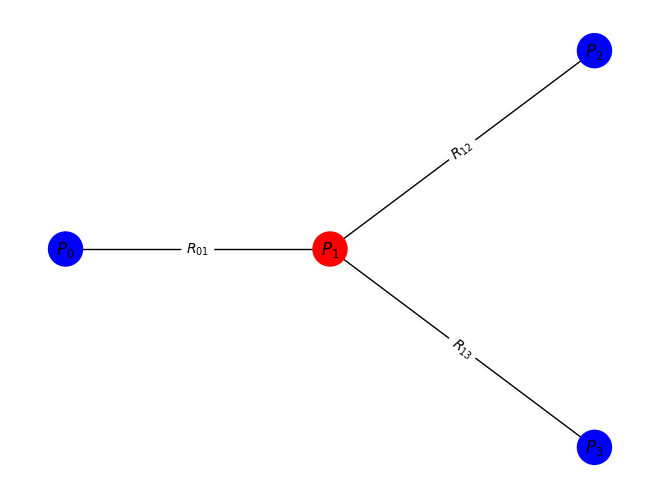

In [10]:
import networkx as nx
G = nx.Graph([(0,1),(1,2),(1,3)])
pos = {0:(0,0),1:(1,0),2:(2,1),3:(2,-1)}
nx.draw(G,pos,labels = {0:"$P_0$",1:"$P_1$",2:"$P_2$",3:"$P_3$"},node_color = ("blue","red","blue","blue"), node_size=600)
nx.draw_networkx_edge_labels(
    G, pos,
    edge_labels={(0, 1): '$R_{01}$',
                 (1, 2): '$R_{12}$',
                 (1, 3): '$R_{13}$'},
    font_color='black'
);

Imagine we set at the blue nodes the inflow pressure $P_0$ and the outflow pressures $P_2$ and $P_3$. We want to calculate the pressure at the red node $P_1$.

The resistances of the capillaries are given by $R_{01}$ for the capillary connecting node 0 to node 1, $R_{12}$ for the capillary connecting node 1 to node 2, and $R_{13}$ for the capillary connecting node 1 to node 3.    

By Poiseuille's law, we know the flow rates into and out of node $P_1$ are:

\begin{equation}
Q_\text{in} = \frac{P_0 - \color{red}{P_1}}{R_{01}}\\
Q_\text{out} = \frac{\color{red}{P_1} - P_2}{R_{12}} + \frac{\color{red}{P_1} - P_3}{R_{13}}
\end{equation}

Conservation of mass states that $Q_\text{in} = Q_\text{out}$, so that we have:

\begin{equation}
\frac{P_0 - \color{red}{P_1}}{R_{01}} = \frac{\color{red}{P_1} - P_2}{R_{12}} + \frac{\color{red}{P_1} - P_3}{R_{13}}.
\end{equation}

This equation can be solved to find $P_1$.

Larger networks require us to solve an equation for each node that is not an inflow or an outflow node. This involves solving simultaneous equations, which can be done efficiently using matrices.

**Example 2**

Consider the larger network below:

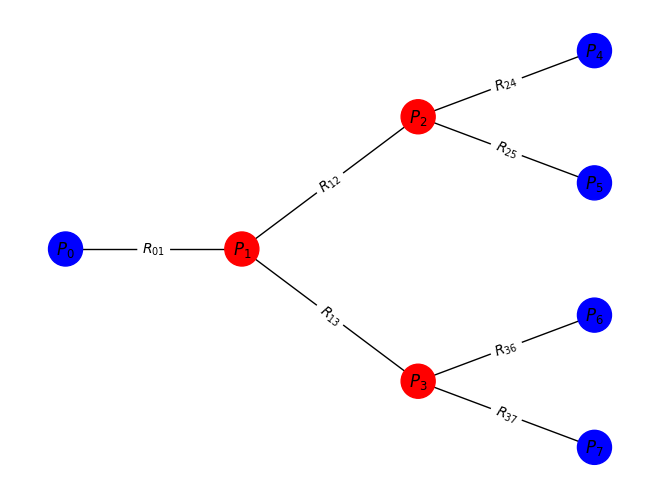

In [12]:
import networkx as nx
G = nx.Graph([(0,1),(1,2),(1,3),(2,4),(2,5),(3,6),(3,7)])
pos = {0:(0,0),1:(1,0),2:(2,1),3:(2,-1),4:(3,1.5),5:(3,0.5),6:(3,-0.5),7:(3,-1.5)}
nx.draw(G,pos,labels = {0:"$P_0$",1:"$P_1$",2:"$P_2$",3:"$P_3$",4:"$P_4$",5:"$P_5$",6:"$P_6$",7:"$P_7$"},node_color = ("blue","red","red","red","blue","blue","blue","blue"), node_size=600)
nx.draw_networkx_edge_labels(
    G, pos,
    edge_labels={(0, 1): '$R_{01}$',
                 (1, 2): '$R_{12}$',
                 (1, 3): '$R_{13}$',
                 (2, 4): '$R_{24}$',
                 (2, 5): '$R_{25}$',
                 (3, 6): '$R_{36}$',
                 (3, 7): '$R_{37}$'},
    font_color='black'
);

# **Activities**

**Beginner activities**

1. Run the code below and inspect the output. Can you investigate how changing the resistance of each capillary affects the blood flow in the network?
2. Do some research online or in a textbook to investigate how matrices work (e.g. addition/subtraction, multiplication). Can you explain why matrices can be used to represent simultaneous equations? Write some code in Python that can add, subtract and/or multiply matrices, to test your understanding.
3. Continue your research to investigate how to solve simultaneous equations by inverting matrices. Write some code in Python that can solve a matrix equation.
4. Can you edit the code below (specifically, the "Define network topology" section) to change the network structure? For example, can you add an extra two branching vessels at the end of the network?

**Intermediate activities**

1. Look up the derivation of Poiseuille's law.
2. Edit the code below to investigate the effect of network structure.
3. Edit the code below so that the flow rate into the network is imposed, instead of the pressure drop across the network.

**Advanced activities**

1. By editing the code below, investigate how network structure affects flow in the network.
2. Do some research on power law fluids. How does the relationship between pressure drop and flow rate change for this type of fluid? Write some code to solve for flow and pressure in a network with a power law fluid. This is not possible using matrices and will require an optimisation algorithm to enforce conservation of mass at all the nodes. You could check that your code agrees with the code below in the limit that the power law fluid becomes Newtonian (when the flow behaviour index is 1).
3. Do some research on more realistic ways to model blood flow that account for hematocrit variations in the network and their effects (e.g. plasma skimming, Fahreus-Lindqvist effect). Write some code that accounts for these effects in arbitrary networks.
4. Think of a different interesting question about blood flow in networks and investigate it yourself - the code below might be a useful starting point.


# **Code**

**Preamble**

First we import the relevant Python libraries.

In [ ]:
import numpy as np
import networkx as nx

**Define network topology**

The variables alpha and beta each contain a list of nodes. Each node in alpha connects to the corresponding node in beta to make an edge. For example, if alpha = [0,1,1] and beta = [1,2,3], then we have the following edges: [0,1], [1,2], [1,3].

We also specify the inlet nodes and the outlet nodes. These should cover all nodes that only connect to one other node. e.g. in the example above, we could specify that node 0 is an inlet node, and that nodes 2 and 3 are outlet nodes.

In [ ]:
#upstream node IDs
alpha = np.array([0,1,1]);
#downstream node IDs
beta = np.array([1,2,3]);
#boundary nodes
inlet_nodes = np.array([0]);
outlet_nodes = np.array([2,3]);
#Number of nodes
N = np.amax([alpha,beta])+1;
#Number of edges
E = np.size(alpha)

**Define parameters**

Here define the input pressure and the resistances of each edge.

In [ ]:
Pin = 1;
#Input resistances
R = a = np.ones((N,1),dtype='float32') #define as float to allow negative powers later

**Construct matricers**

Here is the important bit - constructing the matrices to solve for the pressures. This shouldn't need to be changed if the network structure changes (within certain constraints).

In [ ]:
#-----Initialise matrices to solve for pressures later-----#
A = np.identity(N);
a = np.zeros((N,1));

#-----Construct matrices to solve for pressures-----#
for i in range(0,N):
    #ignore outlets
    if i in outlet_nodes:
      continue
    #ignore inlets and set input pressure
    if i in inlet_nodes:
      a[i,0] = Pin;
      continue
    #find nodes that connect to node i
    ii = np.where(alpha == i)[0] #downstream nodes
    jj = np.where(beta == i)[0] #upstream nodes
    #sum of inverse of connecting resistances
    K = np.sum(np.power(R[ii],-1)) + np.sum(np.power(R[jj],-1))
    #K=sum(R(ii).^(-1))+sum(R(c2).^(-1));
    for j in ii:
      A[i,beta[j]]=-np.power(R[j],-1)/K;
    for j in jj:
      A[i,alpha[j]]=-np.power(R[j],-1)/K;

**Solve for pressures**

Now that the matrices have been constructed, all we need to do is solve the matrix equation for the pressures.

In [ ]:
#-----Solve for pressures-----#
p = np.linalg.solve(A, a)

**Plotting**

Finally, we plot a simple visualisation of the graph with pressures labelled at the nodes. We do this using networkx (https://networkx.org/). Note that we convert the solution variable p to a dictionary that gives the pressure at each node.

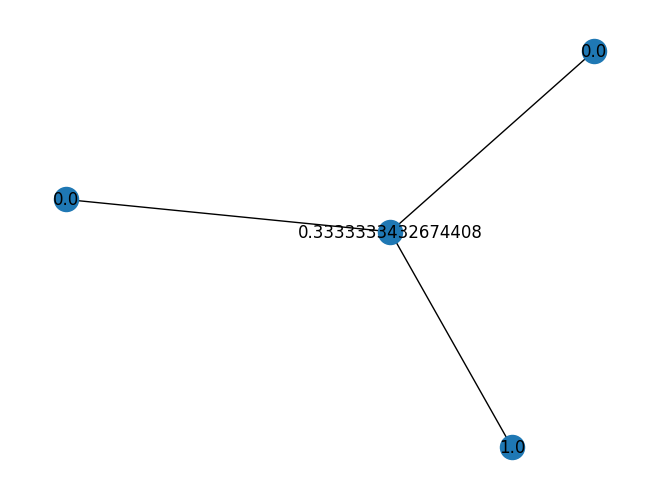

In [ ]:
#Initialise graph
G = nx.Graph()
#Construct graph
for i in range(0,E):
  G.add_edge(alpha[i],beta[i])
#Plot graph
nx.draw(G,labels=dict(zip(range(0,N),tuple(p.reshape(1, -1)[0]))))